In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
from google.colab import output
output.enable_custom_widget_manager()

In [28]:
import os
import sys
sys.path.append('.')

from pathlib import Path


In [29]:
conform_path = 'MyDrive/conform/CONFORM' #modify this depending on your folders
env_path = Path('/content/drive') / conform_path

if str(env_path) not in sys.path:
    sys.path.append(str(env_path))

In [30]:
# getting some warnings and errors here but the model is working somehow
# (ERROR: pip's dependency resolver does not currently take into account all the packages that are installed)

# system packages
!apt-get update
!apt-get install -y libgmp-dev libgnutls30 libidn2-0 libjpeg-dev libtiff-dev libwebp-dev liblz4-dev libbz2-dev libarchive-dev libyaml-dev libzstd-dev

# python packages
!pip install torch torchvision torchaudio accelerate==0.28.0 anyio==4.3.0 argon2-cffi==23.1.0 argon2-cffi-bindings==21.2.0 \
            arrow==1.3.0 asttokens==2.4.1 async-lru==2.0.4 attrs==23.2.0 babel==2.14.0 beautifulsoup4==4.12.3 \
            bleach==6.1.0 cffi==1.16.0 comm==0.2.2 debugpy==1.8.1 decorator==5.1.1 defusedxml==0.7.1 diffusers==0.21.4 \
            executing==2.0.1 fastjsonschema==2.19.1 fqdn==1.5.1 fsspec==2024.3.1 h11==0.14.0 httpcore==1.0.5 httpx==0.27.0 \
            huggingface-hub==0.22.2 importlib-metadata==7.1.0 ipykernel==6.29.4 ipython==8.23.0 ipywidgets==8.1.2 \
            isoduration==20.11.0 jedi==0.19.1 joblib==1.3.2 json5==0.9.24 jsonpointer==2.4 jsonschema==4.21.1 \
            jsonschema-specifications==2023.12.1 jupyter==1.0.0 jupyter-client==8.6.1 jupyter-console==6.6.3 \
            jupyter-core==5.7.2 jupyter-events==0.10.0 jupyter-lsp==2.2.4 jupyter-server==2.13.0 jupyter-server-terminals==0.5.3 \
            jupyterlab==4.1.5 jupyterlab-pygments==0.3.0 jupyterlab-server==2.25.4 jupyterlab-widgets==3.0.10 \
            matplotlib-inline==0.1.6 mistune==3.0.2 nbclient==0.10.0 nbconvert==7.16.3 nbformat==5.10.4 nest-asyncio==1.6.0 \
            notebook==7.1.2 notebook-shim==0.2.4 overrides==7.7.0 packaging==24.0 pandocfilters==1.5.1 parso==0.8.3 \
            pexpect==4.9.0 platformdirs==4.2.0 prometheus-client==0.20.0 prompt-toolkit==3.0.43 psutil==5.9.8 ptyprocess==0.7.0 \
            pure-eval==0.2.2 pycparser==2.22 pygments==2.17.2 python-dateutil==2.9.0.post0 python-json-logger==2.0.7 \
            pytorch-metric-learning==2.5.0 pyzmq==25.1.2 qtconsole==5.5.1 qtpy==2.4.1 referencing==0.34.0 regex==2023.12.25 \
            rfc3339-validator==0.1.4 rfc3986-validator==0.1.1 rpds-py==0.18.0 safetensors==0.4.2 scikit-learn==1.4.1.post1 \
            scipy==1.13.0 send2trash==1.8.2 six==1.16.0 sniffio==1.3.1 soupsieve==2.5 stack-data==0.6.3 terminado==0.18.1 \
            threadpoolctl==3.4.0 tinycss2==1.2.1 tokenizers==0.15.2 tornado==6.4 tqdm==4.66.2 traitlets==5.14.2 \
            transformers==4.39.3 types-python-dateutil==2.9.0.20240316 uri-template==1.3.0 wcwidth==0.2.13 webcolors==1.13 \
            webencodings==0.5.1 websocket-client==1.7.0 widgetsnbextension==4.0.10 zipp==3.18.1


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

# Initialize Model

In [330]:
import torch
from diffusers import StableDiffusionPipeline
from pipeline_conform import ConformPipeline

pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"

sd_pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path=pretrained_model_name_or_path,
    torch_dtype=torch.float16,
).to("cuda")

pipeline = ConformPipeline(
    vae=sd_pipeline.vae,
    text_encoder=sd_pipeline.text_encoder,
    tokenizer=sd_pipeline.tokenizer,
    unet=sd_pipeline.unet,
    scheduler=sd_pipeline.scheduler,
    safety_checker=sd_pipeline.safety_checker,
    feature_extractor=sd_pipeline.feature_extractor,
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

# Hyperparameter

In [331]:

num_inference_steps = 20 # Number of steps to run the model
guidance_scale = 7.5 # Guidance scale for diffusion
attn_res = (16, 16) # Resolution of the attention map to apply CONFORM
steps_to_save_attention_maps = list(range(num_inference_steps)) # Steps to save attention maps
max_iter_to_alter = 30 # Which steps to stop updating the latents
refinement_steps = 20 # Number of refinement steps
scale_factor = 20 # Scale factor for the optimization step
iterative_refinement_steps = [0, 1, 3, 5, 10, 20] # Iterative refinement steps
do_smoothing = True # Apply smoothing to the attention maps
smoothing_sigma = 0.5 # Sigma for the smoothing kernel
smoothing_kernel_size = 3 # Kernel size for the smoothing kernel
temperature = 0.5 # Temperature for the contrastive loss
softmax_normalize = False # Normalize the attention maps
softmax_normalize_attention_maps = False # Normalize the attention maps
add_previous_attention_maps = True # Add previous attention maps to the loss calculation
previous_attention_map_anchor_step = None # Use a specific step as the previous attention map
loss_fn = "ntxent" # Loss function to use
seed = 4913 # Seed for the generation
# seed = 4812 # Seed for the generation


# Prompt

In [332]:
# prompt = "cat under the table"
prompt = "cat at the right of a dog"

## Indices

In [333]:
ids = pipeline.tokenizer(prompt).input_ids
indices = {
    i: tok
    for tok, i in zip(pipeline.tokenizer.convert_ids_to_tokens(ids), range(len(ids)))
}
print(indices)

{0: '<|startoftext|>', 1: 'cat</w>', 2: 'at</w>', 3: 'the</w>', 4: 'right</w>', 5: 'of</w>', 6: 'a</w>', 7: 'dog</w>', 8: '<|endoftext|>'}


## Token Groups

In [334]:
# token_groups = [
#     [1],
#     [2, 4]
# ]

token_groups = [
    [1, 4],
    [7]
]

In [335]:
# Define bounding boxes for tokens [x_min, y_min, x_max, y_max] origin point is top left of the image
# bounding_boxes = {
#     1: [0.1, 0.5, 0.4, 0.9],  # Bounding box for "cat"
#     4: [0.1, 0.1, 0.9, 0.4],  # Bounding box for "table"
# }

bounding_boxes = {
    1: [0.4, 0.1, 0.9, 0.9],  # Bounding box for "table"
    7: [0.1, 0.1, 0.4, 0.9],  # Bounding box for "cat"
}

In [336]:
# img_size = (16,16)

# for token_idx, bbox in bounding_boxes.items():
#   for coord, size in zip(bbox, img_size*2):
#     print(int(coord * size))

## CONFORM Output

In [337]:
images, attention_maps = pipeline(
    prompt=prompt,
    token_groups=token_groups,
    bounding_boxes=bounding_boxes,
    guidance_scale=guidance_scale,
    generator=torch.Generator("cuda").manual_seed(seed),
    num_inference_steps=num_inference_steps,
    max_iter_to_alter=max_iter_to_alter,
    attn_res=attn_res,
    scale_factor=scale_factor,
    iterative_refinement_steps=iterative_refinement_steps,
    steps_to_save_attention_maps=steps_to_save_attention_maps,
    do_smoothing=do_smoothing,
    smoothing_sigma=smoothing_sigma,
    smoothing_kernel_size=smoothing_kernel_size,
    temperature=temperature,
    refinement_steps=refinement_steps,
    softmax_normalize=softmax_normalize,
    softmax_normalize_attention_maps=softmax_normalize_attention_maps,
    add_previous_attention_maps=add_previous_attention_maps,
    previous_attention_map_anchor_step=previous_attention_map_anchor_step,
    loss_fn=loss_fn,
)

  0%|          | 0/20 [00:00<?, ?it/s]

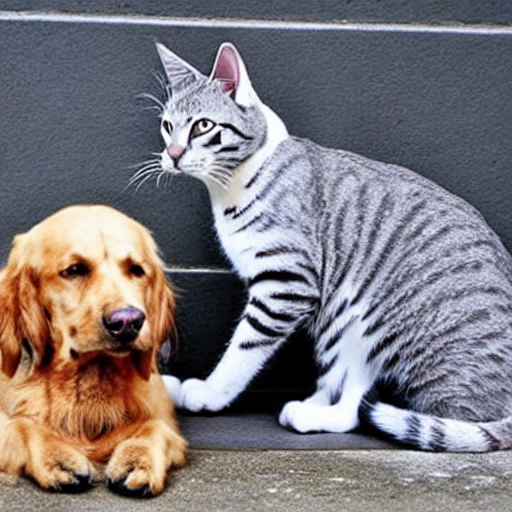

In [338]:
images[0]

## SD Output

In [339]:
out = sd_pipeline(
    prompt=prompt,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    generator=torch.Generator("cuda").manual_seed(seed),
)

  0%|          | 0/20 [00:00<?, ?it/s]

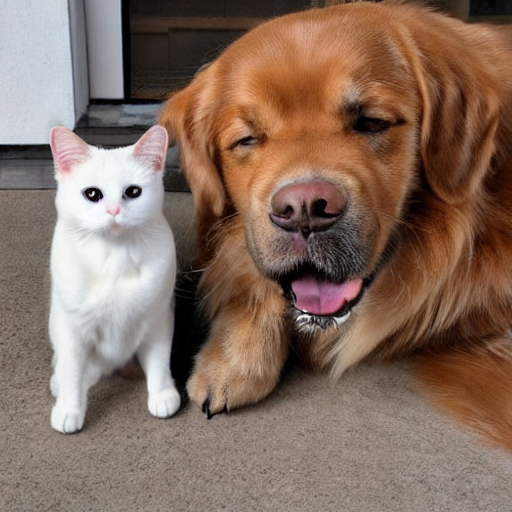

In [340]:
out.images[0]

In [341]:
attention_maps[0]

{0: tensor([[[8.3594e-01, 6.9199e-03, 3.5286e-03,  ..., 1.6189e-04,
           1.6248e-04, 1.6344e-04],
          [8.2959e-01, 9.0790e-03, 2.8610e-03,  ..., 1.8334e-04,
           1.8430e-04, 1.8346e-04],
          [8.1641e-01, 9.4147e-03, 2.9469e-03,  ..., 1.6129e-04,
           1.6212e-04, 1.6284e-04],
          ...,
          [8.3105e-01, 7.5455e-03, 2.3689e-03,  ..., 1.4377e-04,
           1.4484e-04, 1.4651e-04],
          [8.2129e-01, 7.0267e-03, 2.4815e-03,  ..., 2.4164e-04,
           2.4319e-04, 2.4748e-04],
          [8.2959e-01, 7.3929e-03, 3.0575e-03,  ..., 2.2531e-04,
           2.2662e-04, 2.2388e-04]],
 
         [[8.2715e-01, 8.3313e-03, 3.4676e-03,  ..., 1.5724e-04,
           1.5712e-04, 1.5759e-04],
          [8.7354e-01, 1.1513e-02, 3.9024e-03,  ..., 1.5330e-04,
           1.5390e-04, 1.5557e-04],
          [8.7354e-01, 7.4768e-03, 2.5654e-03,  ..., 1.2994e-04,
           1.2994e-04, 1.3280e-04],
          ...,
          [8.4521e-01, 1.1246e-02, 4.0131e-03,  ..., 1.

In [342]:
attn_map = attention_maps[0][19]

print(attn_map.shape)


torch.Size([16, 16, 77])


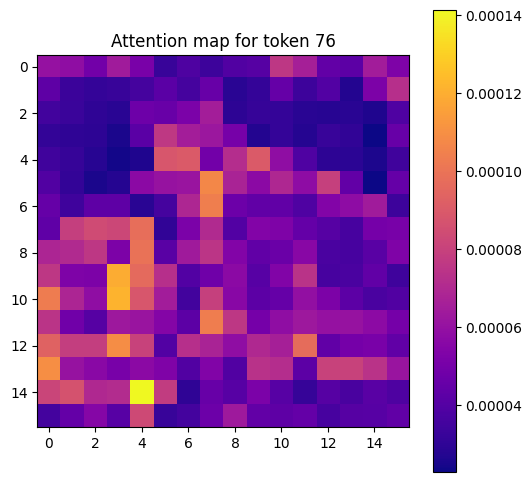

In [343]:
import matplotlib.pyplot as plt

# Choose a token index (e.g., 0 for CLS token)
token_idx = 76  # Change this to visualize other tokens
attn_map_for_token = attn_map[:, :, token_idx]

plt.figure(figsize=(6, 6))
plt.title(f"Attention map for token {token_idx}")
plt.imshow(attn_map_for_token, cmap="plasma")
plt.colorbar()
plt.show()


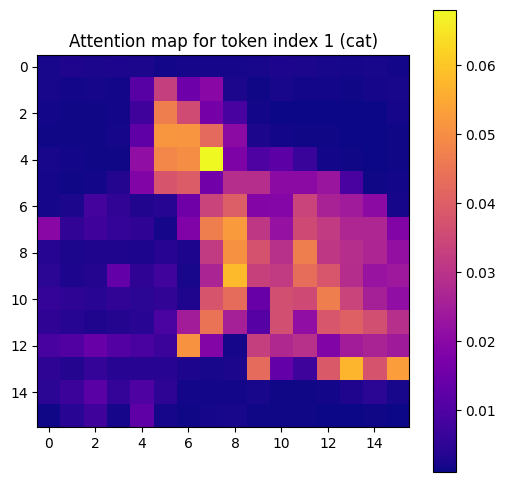

In [344]:
# Visualize the token corresponding to "cat"
# token_idx = 1
token_idx = 1
attn_map_for_token = attn_map[:, :, token_idx]

plt.figure(figsize=(6, 6))
plt.title(f"Attention map for token index {token_idx} (cat)")
plt.imshow(attn_map_for_token, cmap="plasma")
plt.colorbar()
plt.show()


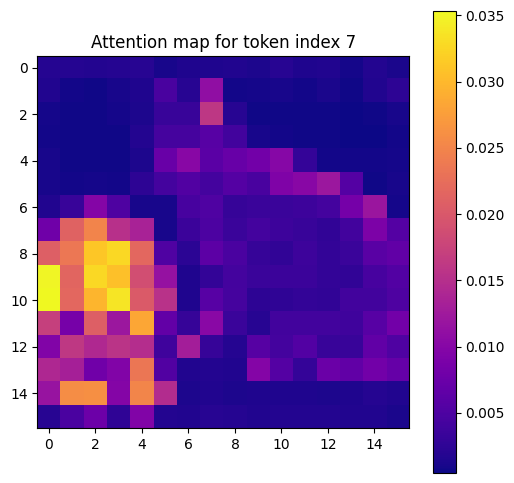

In [345]:
# Visualize the token corresponding to "table"
# token_idx = 4
token_idx = 7
attn_map_for_token = attn_map[:, :, token_idx]

plt.figure(figsize=(6, 6))
plt.title(f"Attention map for token index {token_idx}")
plt.imshow(attn_map_for_token, cmap="plasma")
plt.colorbar()
plt.show()

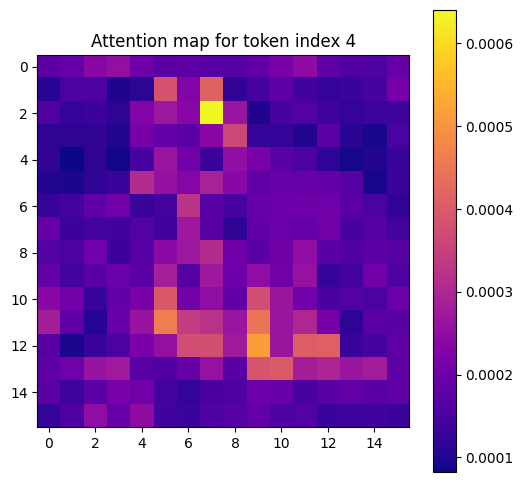

In [346]:
# Visualize the token corresponding to "under"
# token_idx = 2
token_idx = 4
attn_map_for_token = attn_map[:, :, token_idx]

plt.figure(figsize=(6, 6))
plt.title(f"Attention map for token index {token_idx}")
plt.imshow(attn_map_for_token, cmap="plasma")
plt.colorbar()
plt.show()

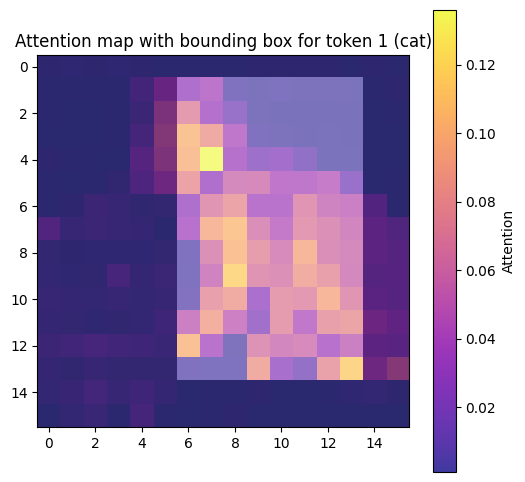

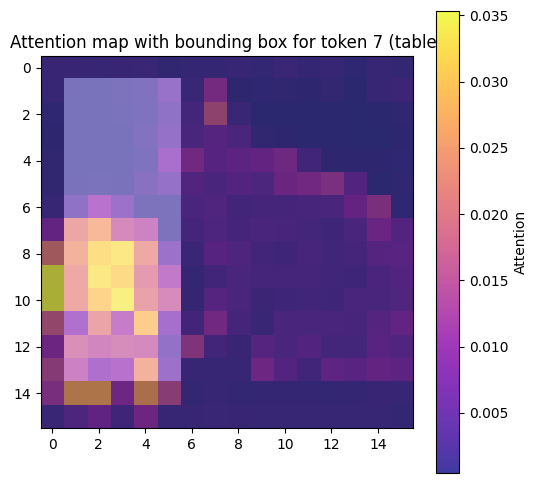

In [347]:
# Function to create bounding box mask
def create_bbox_mask(bbox, grid_size):
    mask = torch.ones(grid_size)
    x_min, y_min, x_max, y_max = [
        int(coord * size) for coord, size in zip(bbox, grid_size*2)
    ]
    mask[y_min:y_max, x_min:x_max] = 2
    return mask

# Visualize the attention map with bounding box for "cat"
# token_idx = 1  # Token for "cat"
token_idx = 1
attn_map_for_token = attn_map[:, :, token_idx].cpu().numpy()

# Create bounding box mask
bbox_cat = bounding_boxes[token_idx]  # Get bounding box for "cat"
bbox_mask_cat = create_bbox_mask(bbox_cat, attn_map_for_token.shape)

attn_map[:, :, token_idx] *= bbox_mask_cat

# Plot the attention map
plt.figure(figsize=(6, 6))
plt.title(f"Attention map with bounding box for token {token_idx} (cat)")
plt.imshow(attn_map_for_token, cmap="plasma", alpha=0.8)
plt.colorbar(label="Attention")

# Overlay the bounding box mask
plt.imshow(bbox_mask_cat, cmap="gray", alpha=0.3)  # Mask with transparency
plt.show()

# Visualize the attention map with bounding box for "table"
# token_idx = 4  # Token for "table"
token_idx = 7
attn_map_for_token = attn_map[:, :, token_idx].cpu().numpy()

# Create bounding box mask
bbox_table = bounding_boxes[token_idx]  # Get bounding box for "table"
bbox_mask_table = create_bbox_mask(bbox_table, attn_map_for_token.shape)

# Plot the attention map
plt.figure(figsize=(6, 6))
plt.title(f"Attention map with bounding box for token {token_idx} (table)")
plt.imshow(attn_map_for_token, cmap="plasma", alpha=0.8)
plt.colorbar(label="Attention")

# Overlay the bounding box mask
plt.imshow(bbox_mask_table, cmap="gray", alpha=0.3)  # Mask with transparency
plt.show()


In [348]:

# # %cd /content/drive/MyDrive/DL/Diffusion-SpaceTime-Attn-main/attention_optimization/stable-diffusion
# %cd /content/drive/MyDrive/conform/CONFORM/LayoutTransformer

# !pip install --upgrade pip==23.0.1

# # 1) (Optional) for torch 1.11.0 + CUDA 11.3
# !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

# # 2) Install pinned versions
# !pip install numpy==1.19.2

# # 3) Install environment_replicate.yml pip deps
# !pip install albumentations==0.4.3 diffusers opencv-python==4.1.2.30 pudb==2019.2 \
#   invisible-watermark imageio==2.9.0 imageio-ffmpeg==0.4.2 \
#   pytorch-lightning==1.4.2 omegaconf==2.1.1 test-tube>=0.7.5 \
#   streamlit>=0.73.1 einops==0.3.0 torch-fidelity==0.3.0 \
#   transformers==4.19.2 torchmetrics==0.6.0 kornia==0.6

# # 4) Install Taming Transformers & CLIP from git
# # !pip install git+https://github.com/CompVis/taming-transformers.git@master
# # !pip install git+https://github.com/openai/CLIP.git@main

# # 5) Additional packages
# !pip install bounding-box==0.1.3 fairseq==0.12.2 spacy==3.5.1 nltk==3.8.1 inflect==6.0.2
# !python -m spacy download en_core_web_sm

# # 6) Install local stable-diffusion package
# # !pip install -e .


In [349]:
# %cd /content/drive/MyDrive/conform/CONFORM/LayoutTransformer

# import nltk
# nltk.download('wordnet')  # Download WordNet
# nltk.download('stopwords')  # Download Stopwords

# # !python inference/inference_coco.py --sentence 'The silver bed was situated to the right of the white couch.'

# !python inference/inference_coco.py --sentence 'The cat is at the right of the table.'
